In [1]:
# 基于iwencai flag的超短线策略: 根据flag期望及分布回测某段时间的策略表现

from opentrader.core.ticker import *
from opentrader.common.db import db_ot
from opentrader.common.utils import d2dt
from opentrader.agents.ths.api import symbol_convert3
from pymongo.errors import *
from datetime import datetime, timedelta

basistags =  ('2005','2006','2007','2008', '2009', '2010', '2011','2012','2013','2014','2015') # 基于哪段数据的统计进行计算
targettag = "2005-2015" # 目标年份
# 回测的时间段
start_date = gen_time('2005-01-01 00:00:00').date()
end_date = gen_time('2015-12-31 00:00:00').date()
date = start_date
dates = []
while date <= end_date:
    if TradeCalendar.check_date(date):
        dates.append(date)
    date += timedelta(1)

In [2]:
# 将k线数据缓存在内存中
kday_cache = {} # {'...symbol...':[{}, {}, {}]}
cur_year = 0
for date in dates:
    if date.year != cur_year:
        print(date.year)
        cur_year = date.year
    else:
        print('.', end='')
    result = db_ot.ths_kday.find({'date':d2dt(date)})
    for each in result:
        if each['symbol'] not in kday_cache:
            kday_cache[each['symbol']] = []
        kday_cache[each['symbol']].append(each)

2005
.................................................................................................................................................................................................................................................2006
................................................................................................................................................................................................................................................2007
.................................................................................................................................................................................................................................................2008
.....................................................................................................................................................................................................................................................2009
........

In [3]:
# 从k线缓存获取数据的工具函数
# only the first day has a calculated "percent" value
def get_k_day_from_date(symbol, date, count=10):
    if symbol not in kday_cache:
        return None
    for (i, each) in enumerate(kday_cache[symbol]):
        if each['date'] == d2dt(date):
            rtn = kday_cache[symbol][i:(i+count)]
            if i > 0:
                if kday_cache[symbol][i-1]['close'] == 0:
                    rtn[0]['percent'] = 0.0
                else:
                    rtn[0]['percent'] = (float(rtn[0]['close']) / float(kday_cache[symbol][i-1]['close']) - 1) * 100
            else:
                rtn[0]['percent'] = 0.0
            return rtn
    return None
    #result = db_ot.ths_kday.find({'symbol':symbol, 'date':{'$gte':d2dt(date)}}).sort('date')
    #return list(result)

#print(get_k_day_from_date("SH601139", datetime(2015, 1, 5, 0, 0)))

In [4]:
# 读取flag期望数据
import json
oneday_result = {}
for basis_year in basistags:
    f = open('iwencai_flag_performance_oneday_'+basis_year+'.json', 'r')
    tmp = json.loads(f.read())
    for (key,val) in tmp.items():
        if key not in oneday_result:
            oneday_result[key] = val
            oneday_result[key]['avr'] = val['count'] * val['avr']
        else:
            oneday_result[key]['count'] += val['count']
            oneday_result[key]['avr'] += val['count'] * val['avr']
    f.close()

for (key,val) in oneday_result.items():
    if oneday_result[key]['count'] > 0:
        oneday_result[key]['avr'] = oneday_result[key]['avr'] / oneday_result[key]['count']
    
onedayf_result = {}
for basis_year in basistags:
    f = open('iwencai_flag_performance_onedayf_'+basis_year+'.json', 'r')
    tmp = json.loads(f.read())
    for (key,val) in tmp.items():
        if key not in onedayf_result:
            onedayf_result[key] = val
            onedayf_result[key]['avr'] = val['count'] * val['avr']
        else:
            onedayf_result[key]['count'] += val['count']
            onedayf_result[key]['avr'] += val['count'] * val['avr']
    f.close()

for (key,val) in onedayf_result.items():
    if onedayf_result[key]['count'] > 0:
        onedayf_result[key]['avr'] = onedayf_result[key]['avr'] / onedayf_result[key]['count']
    
print(len(oneday_result))
print(len(onedayf_result))

597
596


In [5]:
# 计算历史大盘指数并与上证指数比较
f = open('iwencai_flags_withtype.json', 'r')
flags_withtype = json.loads(f.read())
f.close()
indexs = []   # 指数1: 根据buy与sale类型flag次数累计后求平均 
indexs2 = []  # 指数2: 根据所有flag每次出现求和平均后的大盘期望
szzs = []
last_sh = 3000.0
for date in dates: 
    index = 0
    index2 = 0
    totalflags = 0
    for key in ("buy", "sale", "event", "zxst"):
        for flag in flags_withtype[key]:
            result = db_ot.iwencai_flag_history.find_one({'flag':flag, 'date':d2dt(date)})
            if not result:
                continue
            if key == 'buy':
                index += len(result['symbols'])
            elif key == 'sale':
                index -= len(result['symbols'])
            if flag in oneday_result:
                index2 += oneday_result[flag]['avr'] * len(result['symbols'])
            totalflags += len(result['symbols'])
            
    index = index/2666
    if totalflags:
        index2 = index2/totalflags
    else:
        index2 = 0.0
    indexs.append(index)
    indexs2.append(index2)
    sh = float(db_ot.ths_kday.find_one({'symbol':'SH000001', 'date':d2dt(date)})['close'])
    szzs.append(sh)
    print("%s, index:%f, index2:%f, szzs:%f" % (date, index, index2, (sh/last_sh-1.0)*100))
    last_sh = sh
    # 2015重要股灾日： 5.5, 5.28, 6.16, 6.26, 7.27, 8.18, 9.15, 10.21, 11.27

2005-01-04, index:0.469242, index2:0.031863, szzs:-58.574333
2005-01-05, index:1.925356, index2:0.245429, szzs:0.799022
2005-01-06, index:0.633908, index2:0.070001, szzs:-1.059312
2005-01-07, index:2.139160, index2:0.214040, szzs:0.429230
2005-01-10, index:0.570143, index2:0.205109, szzs:0.614581
2005-01-11, index:0.514254, index2:0.160562, szzs:0.404024
2005-01-12, index:-0.063766, index2:0.125783, szzs:-0.042944
2005-01-13, index:0.170668, index2:0.151963, szzs:-0.048531
2005-01-14, index:0.540510, index2:0.148474, szzs:-0.850905
2005-01-17, index:-0.723181, index2:0.013188, szzs:-2.325749
2005-01-18, index:1.145536, index2:0.221424, szzs:0.723298
2005-01-19, index:0.528507, index2:0.096525, szzs:-0.598964
2005-01-20, index:0.098275, index2:0.035651, szzs:-1.126335
2005-01-21, index:2.460990, index2:0.253733, szzs:2.498360
2005-01-24, index:1.397599, index2:0.226167, szzs:1.725423
2005-01-25, index:-0.438485, index2:0.098401, szzs:-0.123429
2005-01-26, index:-0.751688, index2:0.05223

In [6]:
# 计算每天期望值前五名的个股，并记录第二天的平均涨幅
import json, operator
f = open('iwencai_flags.json', 'r')
flags = json.loads(f.read())
f.close()

index2_max = max(indexs2)
date_performance = []
date_performance2 = [] # 考虑仓位变化的持仓股票performance
indexs3 = [] # 每天可入手的5支股票期望的平均值
for (idate, date) in enumerate(dates):
    position_counts = round(indexs2[idate]/index2_max/0.05)
    symbol_means = {}
    symbol_max_flag = {}
    for flag in flags:
        if flag in ('停牌','涨停'):# 此处过滤 “涨停” 是为了滤掉ST股票的影响
            continue
        #if '光头' in flag:
        #    continue
        result = db_ot.iwencai_flag_history.find_one({'flag':flag, 'date':d2dt(date)})
        if not result:
            continue
        for symbol in result['symbols']:
            if symbol not in symbol_means:
                symbol_means[symbol] = []
            try:
                symbol_means[symbol].append(onedayf_result[flag]['avr'])
                if symbol not in symbol_max_flag or onedayf_result[flag]['avr'] > onedayf_result[symbol_max_flag[symbol]]['avr']:
                    symbol_max_flag[symbol] = flag
            except KeyError:
                continue
    for symbol,means in symbol_means.items():
        if len(means):
            symbol_means[symbol] = sum(means)/len(means)
        else:
            symbol_means[symbol] = 0.0
    symbol_means_sorted = sorted(symbol_means.items(), key=operator.itemgetter(1), reverse=True)
    performance = []
    stocks = []
    i = 0
    for (symbol, mean) in symbol_means_sorted:
        sym = symbol_convert3(symbol)
        #if sym.startswith("SZ300"):
        #    continue
        try:
            kdays = get_k_day_from_date(sym, date)
        except ZeroDivisionError:
            continue
        if kdays is None or len(kdays) < 2 or float(kdays[0]['percent']) > 9.8:
            continue
        if float(kdays[0]['close']) == 0.0:
            continue
        if idate > 0 and float(kdays[0]['percent']) == 0.0: #第一天发行的股票
            continue
        if kdays[0]['date'] != d2dt(date): # 停牌
            continue
        else:
            performance.append((float(kdays[1]['close']) / float(kdays[0]['close']) - 1)*100)
            stocks.append((sym, symbol_max_flag[symbol], mean))
        i += 1
        if i >= 20:
            break
    # 2015重要股灾日： 5.5, 5.28, 6.16, 6.26, 7.27, 8.18, 9.15, 10.21, 11.27
    if len(performance) == 0:
        date_performance.append(0.0)
        date_performance2.append(0.0)
        indexs3.append(0.0)
        print("%s: zero result" % (date))
    else:
        date_performance.append(sum(performance) / len(performance))
        indexs3.append(sum([each[2] for each in stocks]) / len(stocks))
        position_counts = min(position_counts, len(performance))
        if position_counts == 0:
            date_performance2.append(0.0)
        else:
            date_performance2.append(sum(performance[:position_counts]) / position_counts)
        print("%s: available stocks: %s, index2: %f, index3: %f, performance: %f, stocks: %s, position: %f" % (date, len(performance), indexs2[idate], indexs3[idate], sum(performance) / len(performance), stocks, round(indexs2[idate]/index2_max/0.05)*0.05))


2005-01-04: available stocks: 20, index2: 0.031863, index3: 0.237906, performance: 3.622278, stocks: [('SH600073', '低开高走', 0.3080529195200772), ('SH600162', '阳包阴股票', 0.2794412553177142), ('SH600095', '行情收盘价上穿5日均线', 0.2750159078409221), ('SH600725', '一阳二线', 0.271759596309189), ('SH600634', '光头光脚阳线', 0.2559564608246507), ('SZ000505', '光头光脚阳线', 0.2509163959440841), ('SH600335', '金蜘蛛', 0.24325404200199569), ('SH600523', '低开高走', 0.23781214763195352), ('SZ000683', '行情收盘价上穿5日均线', 0.2358646847538746), ('SZ000035', '低开高走', 0.23325526222093493), ('SH600622', '阳包阴股票', 0.2326886368575718), ('SH600756', '一阳二线', 0.23115151055278352), ('SZ000058', '低开高走', 0.22363005817929446), ('SH600498', '金蜘蛛', 0.21638018499448747), ('SH600797', '行情收盘价上穿5日均线', 0.21363195315702932), ('SH600988', '行情收盘价上穿5日均线', 0.21278442642676154), ('SH600536', '弃婴形态', 0.21133927225718457), ('SH600485', '低位大阳', 0.20932432155629702), ('SH600667', '低开高走', 0.20897016165278637), ('SH600292', '一阳二线', 0.20689236544718217)], position: 0.05

full position trade days: 771
941
1or0 trade days: 941
0.6601154694313118
2668
2668


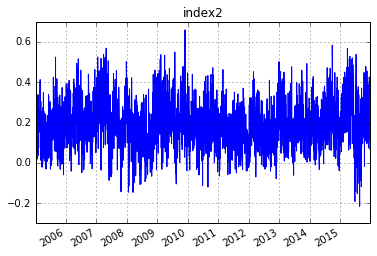

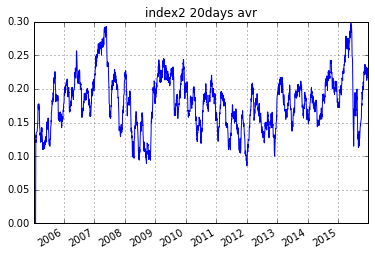

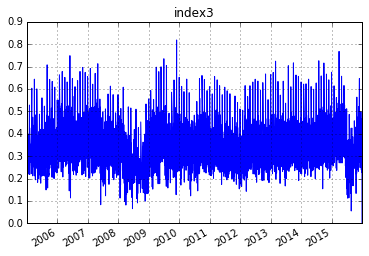

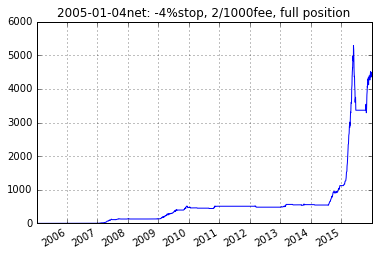

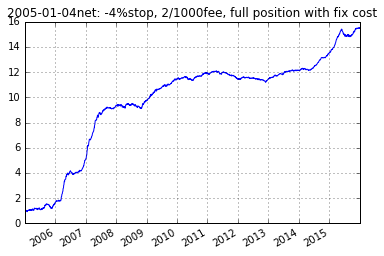

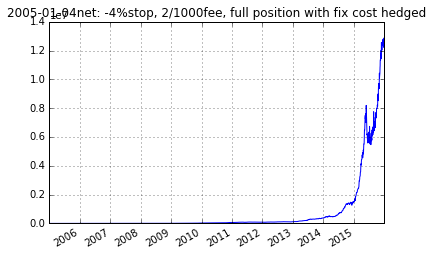

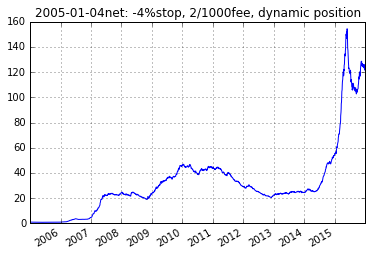

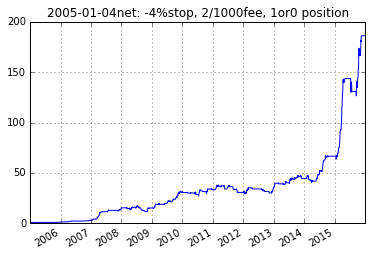

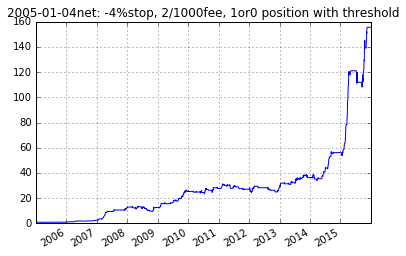

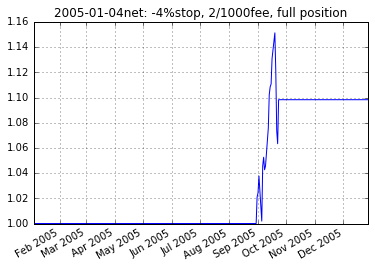

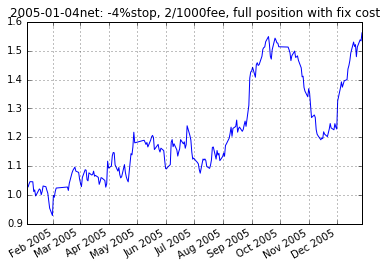

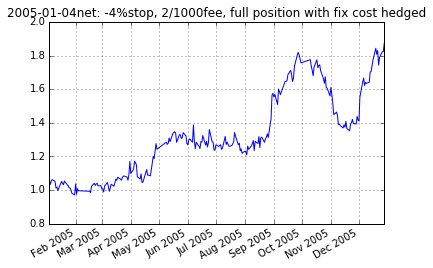

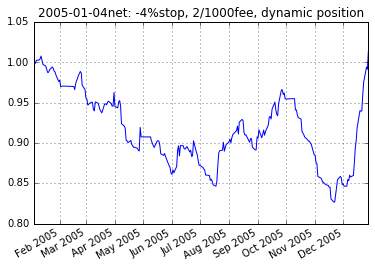

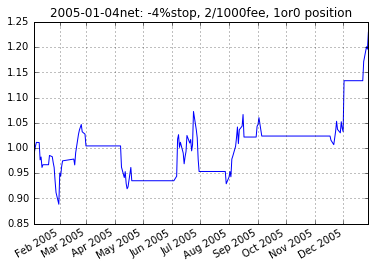

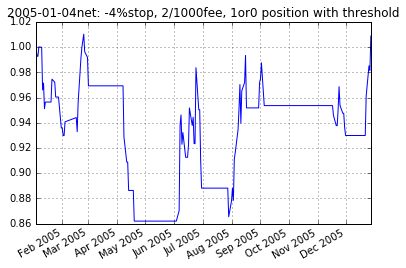

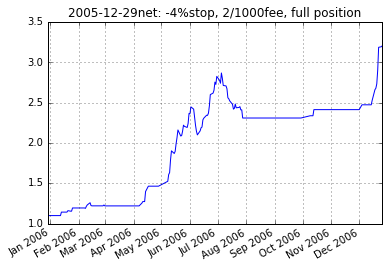

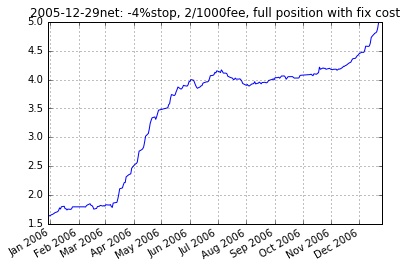

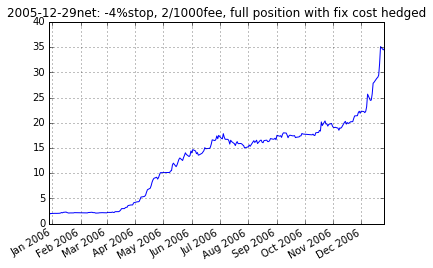

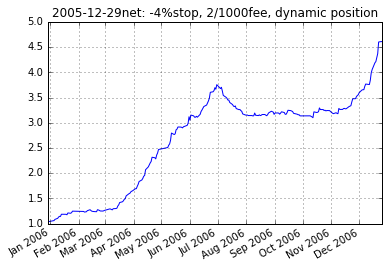

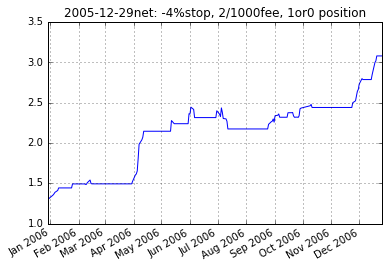

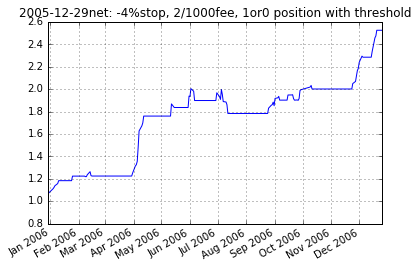

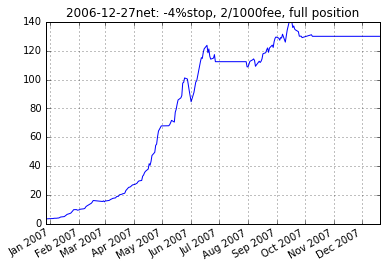

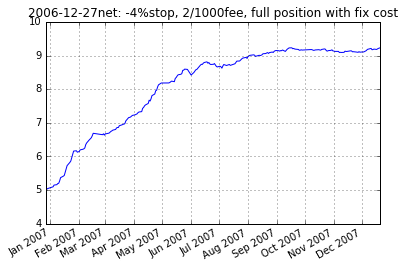

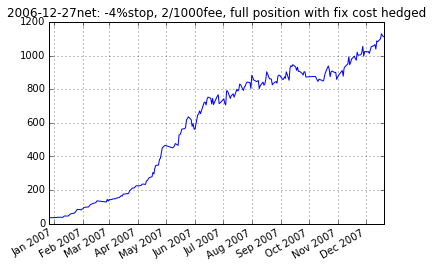

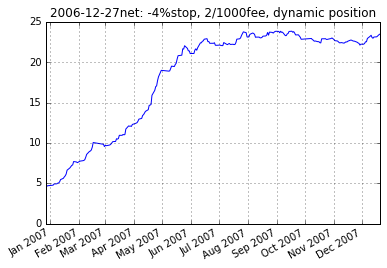

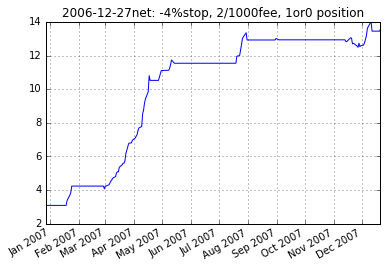

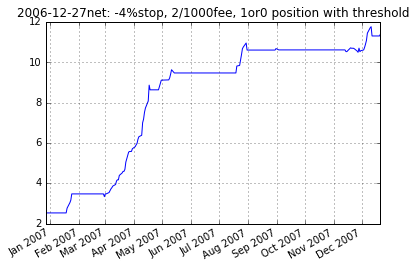

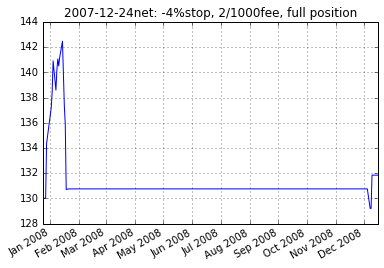

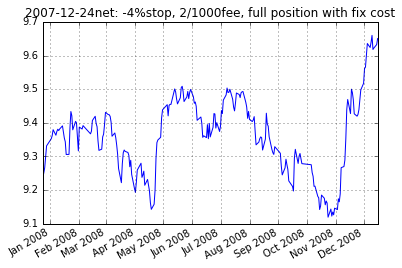

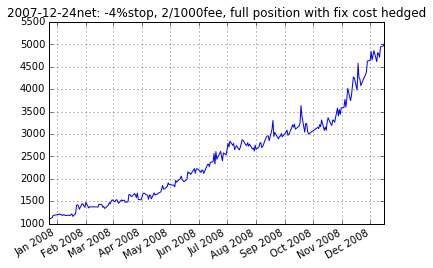

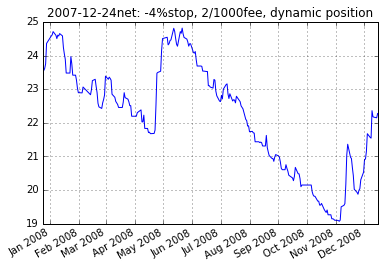

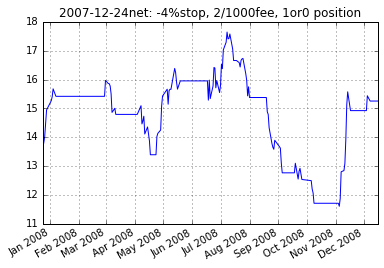

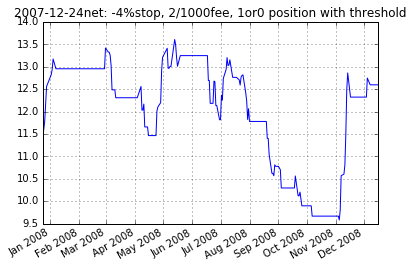

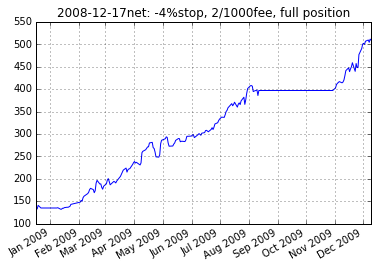

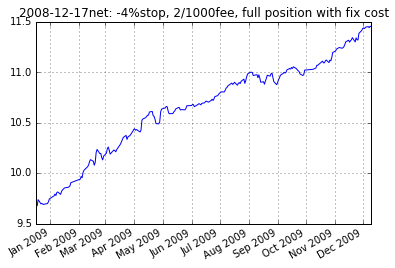

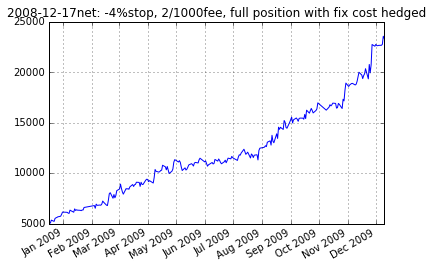

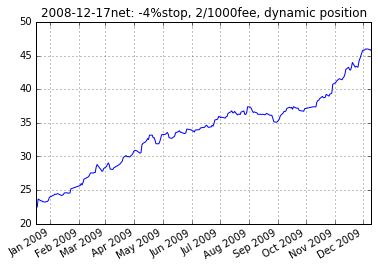

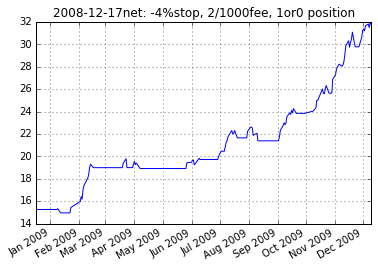

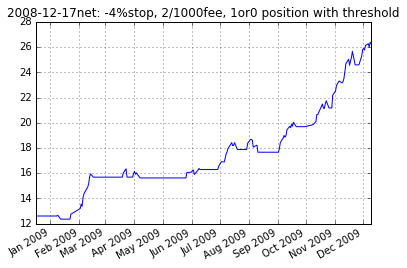

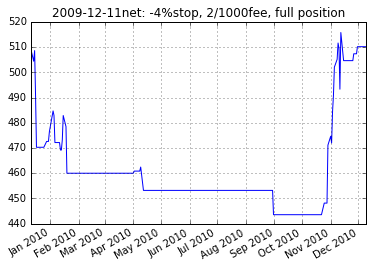

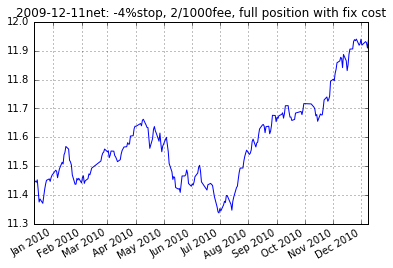

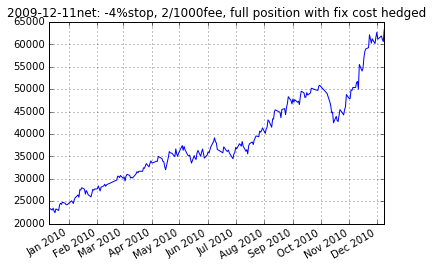

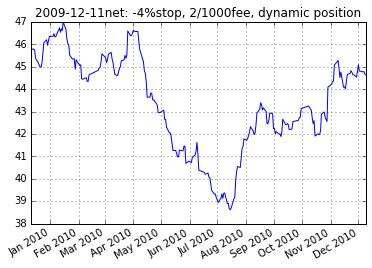

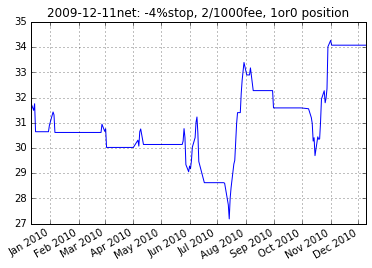

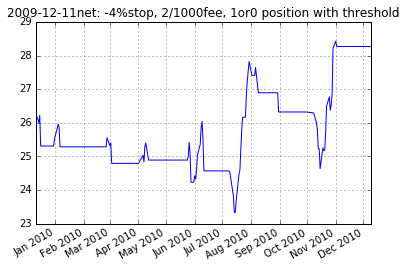

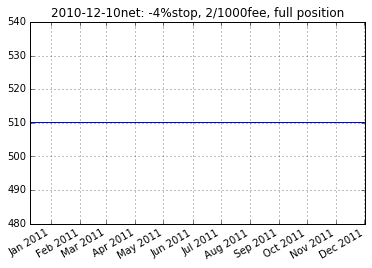

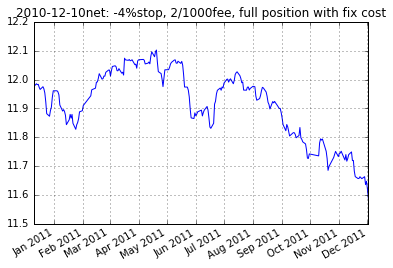

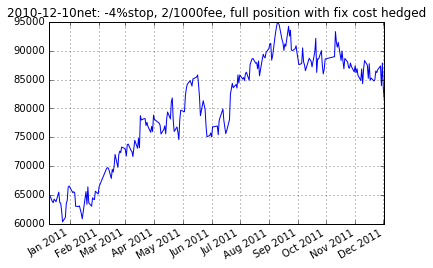

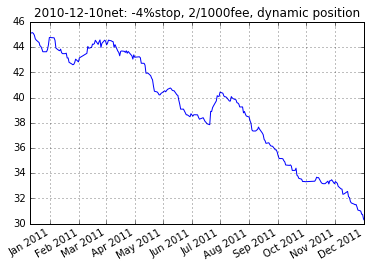

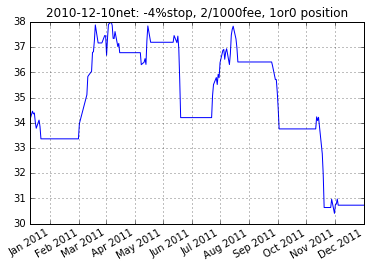

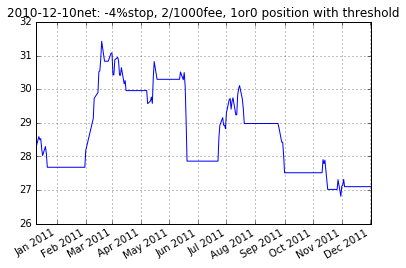

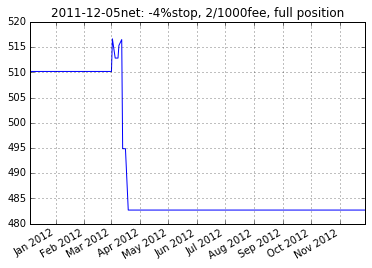

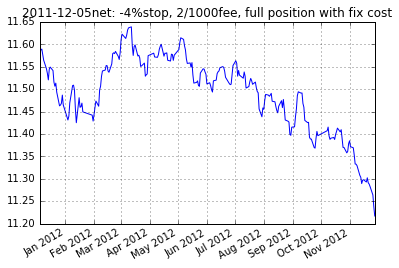

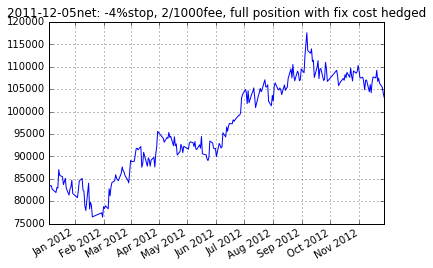

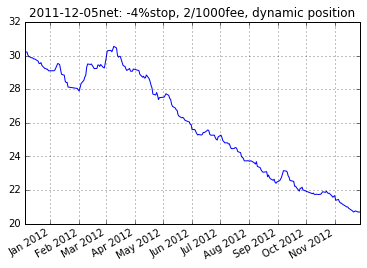

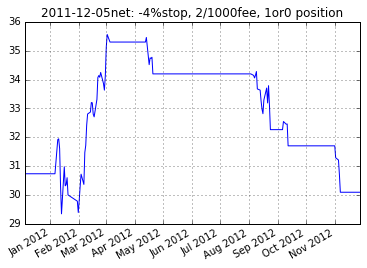

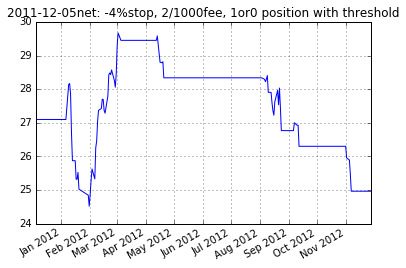

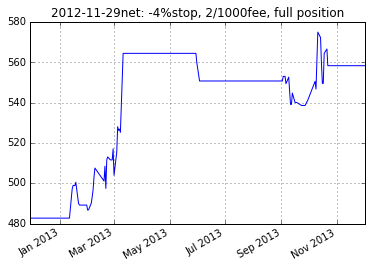

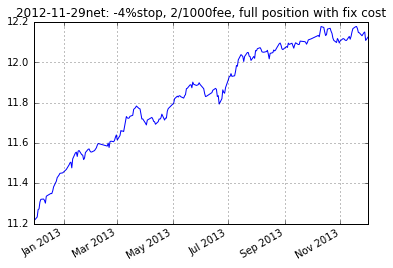

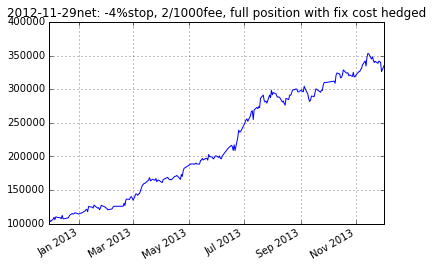

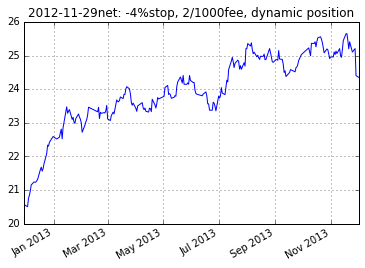

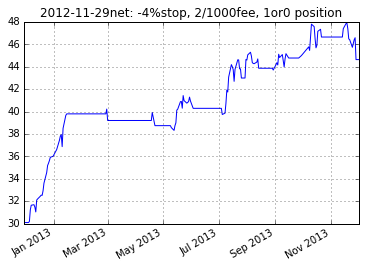

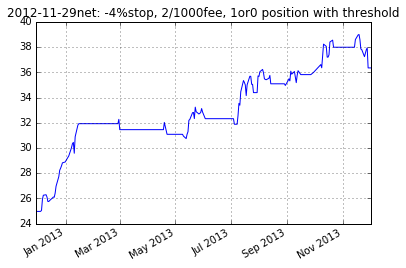

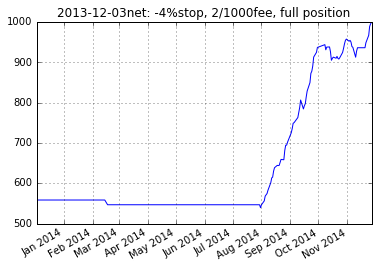

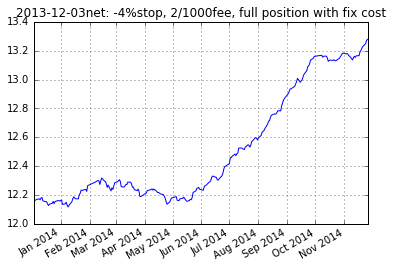

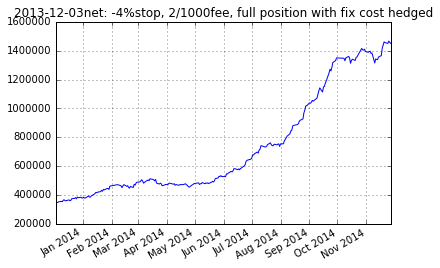

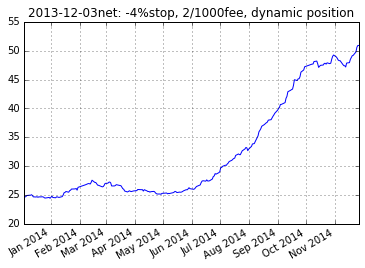

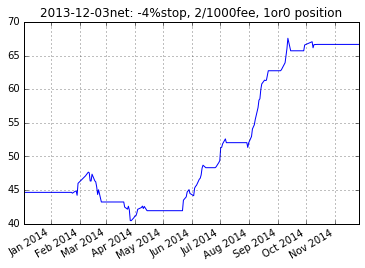

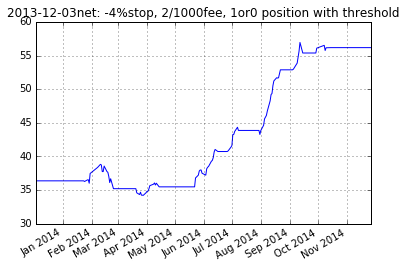

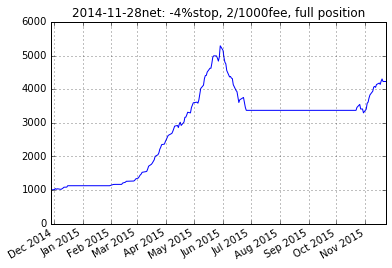

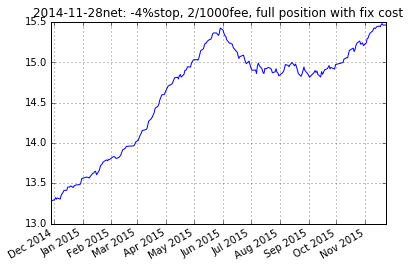

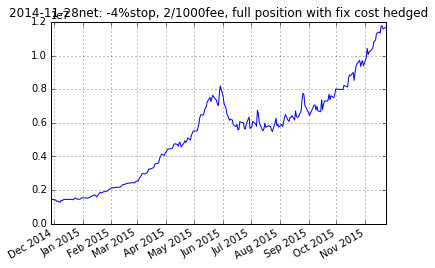

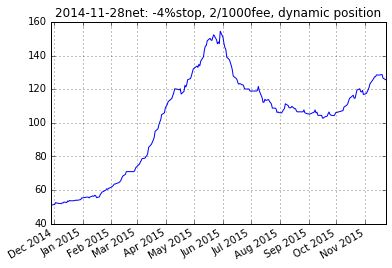

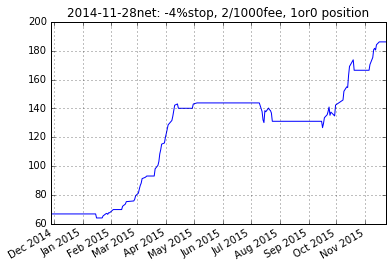

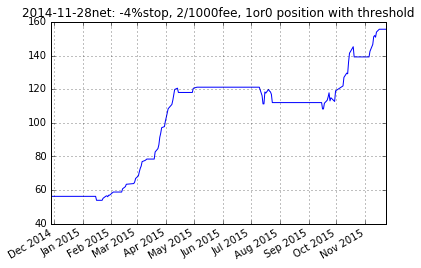

In [12]:
# index2 20day avr
index2_avr_20 = []
avr = 0.0
for (idate, index) in enumerate(indexs2):
    if idate < 19:
        avr += index
        index2_avr_20.append(0.0)
    elif idate == 19:
        avr += index
        avr = avr/20.0
        index2_avr_20.append(avr)
    else: # >= 20
        avr = (avr * 19.0 + index) / 20.0
        index2_avr_20.append(avr)
        
from opentrader.core.crawler import *
c = CNCrawler()
hedge_kday = c.get_k_day("SZ399300", begin="2005-01-01 00:00:00", end="2015-12-31 00:00:00")
hedge_kday_dict = {}
for each in hedge_kday:
    hedge_kday_dict[str(each['date'])] = each['percent']

fund_basic = []
init = 1.0
trade_days = 0
for (idate, each) in enumerate(date_performance):
    if each < -4.0:
        each = -4.0
    if each > 10.0:
        each = 10.0
    if index2_avr_20[idate] < 0.20:
        fund_basic.append(init)
        continue
    init -= 0.002 * init
    init += init*(each/100.0)
    fund_basic.append(init)
    trade_days += 1
print("full position trade days: %d" % trade_days)

fund_basic_fix_cost = []
init = 1.0
base = 1.0 # for fix cost case
for (idate, each) in enumerate(date_performance):
    if each < -4.0:
        each = -4.0
    if each > 10.0:
        each = 10.0
    init -= 0.002 * base
    init += base*(each/100.0)
    fund_basic_fix_cost.append(init)

fund_basic_fix_cost_hedge = []
init = 1.0
base = 1.0 # for fix cost case
for (idate, each) in enumerate(date_performance):
    if each < -4.0:
        each = -4.0
    if each > 10.0:
        each = 10.0
    if str(dates[idate]) in hedge_kday_dict:
        each -=  hedge_kday_dict[str(dates[idate])]
    else:
        print(dates[idate])
    init -= 0.002 * base
    init += init*(each/100.0)
    fund_basic_fix_cost_hedge.append(init)

fund = []
positions = []
init = 1.0
trade_days = 0
for (i, each) in enumerate(date_performance2):
    if indexs2[i] < 0.0:
        fund.append(init)
        positions.append(0.0)
        continue
    if each < -4.0:
        each = -4.0
    if each > 10.0:
        each = 10.0
    #init = init * (1.0 + each/100.0)
    init -= 0.002 * init
    position = float(round(indexs2[i]/index2_max/0.05)*0.05)
    init = init * (1.0 - position) + init * position * (1.0 + each/100.0)
    fund.append(init)
    positions.append(position)
    trade_days += 1

# 确定仓位的方案
#f = open('iwencai_flag_trade_dates.json', 'r')
#trade_dates = json.loads(f.read())
#f.close()
trade_dates = []
recent_highs = []
recent_high_num = 20
recent_lows = []
recent_low_num = 10
status = True
for (idate, each) in enumerate(indexs2):
    if status == True:
        if len(recent_lows) == 0 or each < min(recent_lows):
            status = False
        else:
            trade_dates.append(dates[idate])
    else:
        if len(recent_highs) == 0 or each > max(recent_highs):
            status = True
            trade_dates.append(dates[idate])
    
    # update recent highs and lows
    recent_highs.append(each)
    if len(recent_highs) > recent_high_num:
        recent_highs.pop(0)
    
    recent_lows.append(each)
    if len(recent_lows) > recent_low_num:
        recent_lows.pop(0)
print(len(trade_dates))

fund_1or0 = []
init = 1.0
trade_days = 0
for (idate, each) in enumerate(date_performance):
    #if str(dates[idate]) not in trade_dates:
    if dates[idate] not in trade_dates:
        fund_1or0.append(init)
        continue
    if each < -4.0:
        each = -4.0
    if each > 10.0:
        each = 10.0
    init -= 0.002 * init
    init += init*(each/100.0)
    fund_1or0.append(init)
    trade_days += 1
print("1or0 trade days: %d" % trade_days)

fund_1or0_with_th = []
init = 1.0
for (idate, each) in enumerate(date_performance):
    #if str(dates[idate]) not in trade_dates:
    if dates[idate] not in trade_dates:
        fund_1or0_with_th.append(init)
        continue
    if indexs2[idate] < 0.08:
        fund_1or0_with_th.append(init)
        continue
    if each < -4.0:
        each = -4.0
    if each > 10.0:
        each = 10.0
    init *= 0.998
    init = init * (1.0 + each/100.0)
    fund_1or0_with_th.append(init)
    
print(index2_max)
print(len(dates))
print(len(date_performance))

%matplotlib inline
from opentrader.core.crawler import *
from datetime import datetime
from opentrader.jupyter.lib.plot import *
from opentrader.ceres.account import Account
from opentrader.ceres.trade import *
# 2015重要股灾日： 5.5, 5.28, 6.16, 6.26, 7.27, 8.18, 9.15, 10.21, 11.27
#draw_line("index", dates, [{"value":indexs}])
    

draw_line("index2", dates, [{"value":indexs2}])
draw_line("index2 20days avr", dates, [{"value":index2_avr_20}])
draw_line("index3", dates, [{"value":indexs3}])

#draw_line("position", dates, [{"value":positions}])
draw_line("%snet: -4%%stop, 2/1000fee, full position" % (dates[0]), dates, [{"value":fund_basic}])
draw_line("%snet: -4%%stop, 2/1000fee, full position with fix cost" % (dates[0]), dates, [{"value":fund_basic_fix_cost}])
draw_line("%snet: -4%%stop, 2/1000fee, full position with fix cost hedged" % (dates[0]), dates, [{"value":fund_basic_fix_cost_hedge}])
draw_line("%snet: -4%%stop, 2/1000fee, dynamic position" % (dates[0]), dates, [{"value":fund}])
draw_line("%snet: -4%%stop, 2/1000fee, 1or0 position" % (dates[0]), dates, [{"value":fund_1or0}])
draw_line("%snet: -4%%stop, 2/1000fee, 1or0 position with threshold" % (dates[0]), dates, [{"value":fund_1or0_with_th}])

    
for i in range(int(len(dates)/240)):
    draw_line("%snet: -4%%stop, 2/1000fee, full position" % (dates[i*240]), dates[i*240:(i+1)*240], [{"value":fund_basic[i*240:(i+1)*240]}])
    draw_line("%snet: -4%%stop, 2/1000fee, full position with fix cost" % (dates[i*240]), dates[i*240:(i+1)*240], [{"value":fund_basic_fix_cost[i*240:(i+1)*240]}])
    draw_line("%snet: -4%%stop, 2/1000fee, full position with fix cost hedged" % (dates[i*240]), dates[i*240:(i+1)*240], [{"value":fund_basic_fix_cost_hedge[i*240:(i+1)*240]}])
    draw_line("%snet: -4%%stop, 2/1000fee, dynamic position" % (dates[i*240]), dates[i*240:(i+1)*240], [{"value":fund[i*240:(i+1)*240]}])
    draw_line("%snet: -4%%stop, 2/1000fee, 1or0 position" % (dates[i*240]), dates[i*240:(i+1)*240], [{"value":fund_1or0[i*240:(i+1)*240]}])
    draw_line("%snet: -4%%stop, 2/1000fee, 1or0 position with threshold" % (dates[i*240]), dates[i*240:(i+1)*240], [{"value":fund_1or0_with_th[i*240:(i+1)*240]}])

Index Distribution
0.18047263044


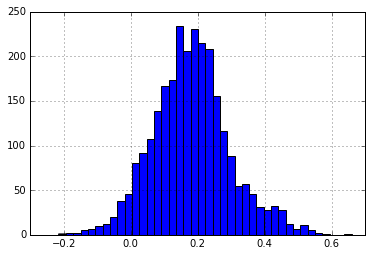

Performance Distribution
0.675210570334


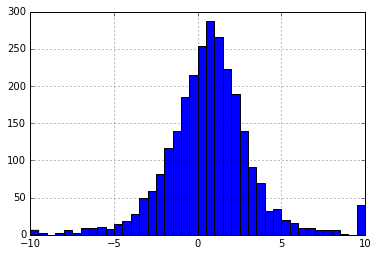

Performance Distribution with 30 day accu
26.9706782128


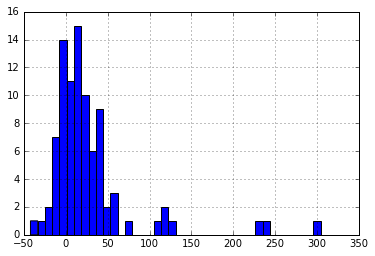

CSI300 Hedged Performance Distribution
0.60867979822


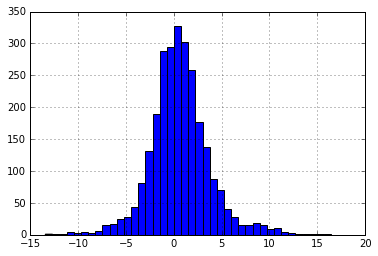

CSI300 Hedged Performance Distribution with 30 day accu
21.3216084676


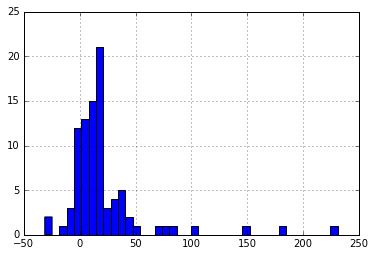

In [28]:
from pandas import Series
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
s = Series(indexs2)
s.hist(bins=40)
print("Index Distribution")
print(s.mean())
plt.show()

perf = []
perf_accu = []
perf_accu_counter = 1.0
hedged_perf = []
hedged_perf_accu = []
hedged_perf_accu_counter = 1.0
for (idate, each) in enumerate(date_performance):
    if each < -10.0:
        each = -10.0
    if each > 10.0:
        each = 10.0
    #if dates[idate] in trade_dates:
    perf.append(each)
    if idate % 30 == 0:
        perf_accu.append((perf_accu_counter - 1.0) * 100.0)
        perf_accu_counter = 1.0
    else:
        perf_accu_counter = perf_accu_counter * (1.0 + each / 100.0)
    
    if str(dates[idate]) in hedge_kday_dict:
        hedged_perf_each = each - hedge_kday_dict[str(dates[idate])]
        hedged_perf.append(hedged_perf_each)
        if idate % 30 == 0:
            hedged_perf_accu.append((hedged_perf_accu_counter - 1.0) * 100.0)
            hedged_perf_accu_counter = 1.0
        else:
            hedged_perf_accu_counter = hedged_perf_accu_counter * (1.0 + hedged_perf_each / 100.0)
    else:
        print(dates[idate])
print("Performance Distribution")
s = Series(perf)
print(s.mean())
s.hist(bins=40)
plt.show()

print("Performance Distribution with 30 day accu")
s = Series(perf_accu)
print(s.mean())
s.hist(bins=40)
plt.show()

print("CSI300 Hedged Performance Distribution")
s = Series(hedged_perf)
print(s.mean())
s.hist(bins=40)
plt.show()

print("CSI300 Hedged Performance Distribution with 30 day accu")
s = Series(hedged_perf_accu)
print(s.mean())
s.hist(bins=40)
plt.show()